In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
#plt.set_cmap('jet');
import random
import os, sys
import pickle
%matplotlib inline

In [2]:
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['a','-thing']
    
parser = argparse.ArgumentParser()

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=50, help='Number of samples for train')
parser.add_argument('-thing', default=False, action='store_true', help='Do the thing')


args = parser.parse_args()

In [3]:
print(args)

Namespace(nsamples=50, seed=0, thing=True)


In [4]:
exp_id = str(args).replace(" ","").replace("Namespace(","").replace(")","").replace(",","-").replace("=","")
print(exp_id)

nsamples50-seed0-thingTrue


In [5]:
torch.manual_seed(args.seed);
random.seed(args.seed)

In [6]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
cuda = torch.cuda.is_available()

In [8]:
BATCH_SIZE = 64

In [9]:
from torch.utils import data
import os
import skimage, skimage.transform
from skimage.io import imread, imsave

In [10]:
from PIL import Image
import skimage.filters

In [11]:
class TNTDataset(data.Dataset):
    'Tumor-NoTumor Dataset loader for PyTorch'
    def __init__(self, tntpath, subset="train", transform=None, blur=0):
        self.tntpath = tntpath
        self.subset = subset
        self.datapath = self.tntpath + "/" + self.subset + "/"
        self.imgs = sorted(os.listdir(self.datapath + "/flair"))
        self.transform = transform
        self.blur = blur

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # Select sample
        filename = self.imgs[index]
        
        flair = imread(self.datapath + "/flair/" + filename)
        flair = Image.fromarray(flair)
        if self.transform != None:
            flair = self.transform(flair)
            
#         t1 = imread(self.datapath + "/t1/" + filename)
#         t1 = Image.fromarray(t1)
#         if self.transform != None:
#             t1 = self.transform(t1)
            
        seg = imread(self.datapath + "/segmentation/" + filename)
        seg = ((seg >= 30))*256.
        
        if self.blur > 0:
            seg = skimage.filters.gaussian(seg, self.blur)
            seg = seg/seg.max()
            
        seg = (seg > 0)*1.
        
        seg = Image.fromarray(seg)
        if self.transform != None:
            seg = self.transform(seg)
        
        
        has_tumor = ("True" in filename)

        return (flair, flair, seg), has_tumor 

In [12]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

In [13]:
train = TNTDataset("/data/lisa/data/brats2013_tumor-notumor/", 
                   transform=mytransform,
                   blur=1)

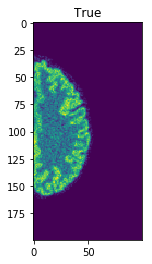

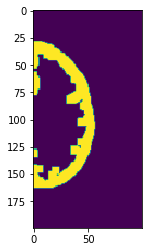

In [14]:
plt.imshow(train[5][0][0][0]);
plt.title(train[5][1]);
plt.show()
plt.imshow(train[5][0][2][0]);

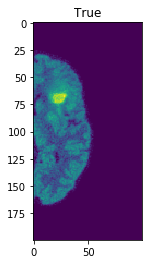

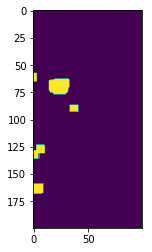

In [15]:
plt.imshow(train[250][0][0][0]);
plt.title(train[250][1]);
plt.show()
plt.imshow(train[250][0][2][0]);

In [16]:
# def f(x):
#     plt.imshow(train[x][0][1][0]);
#     plt.title(train[x][1]);
#     plt.show()
#     plt.imshow(train[x][0][2][0]);

# interact(f, x=(0,len(train),1));

In [17]:
tosplit = np.asarray([("True" in name) for name in train.imgs])
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=args.seed)


/u/cohenjos/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
import collections
collections.Counter(tosplit)

Counter({False: 704, True: 1421})

In [19]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 1593
valid_idx 532


In [20]:
#reduce samples
train_idx = train_idx[:args.nsamples]

In [21]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 50
valid_idx 532


In [22]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx),
                                          num_workers=8)
valid_loader = torch.utils.data.DataLoader(dataset=train, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx),
                                          num_workers=8)

In [23]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0][0]).cuda()
valid_y = valid_data[0][1].cuda()

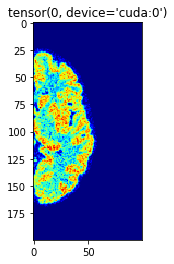

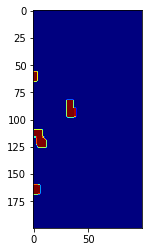

In [24]:
plt.imshow(valid_data[0][0][0][60][0]);
plt.title(valid_y[60]);
plt.show()
plt.imshow(valid_data[0][0][2][60][0]);


In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),     
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [26]:
cnn = CNN()
if cuda:
    cnn = cnn.cuda()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (out): Linear(in_features=440, out_features=2, bias=True)
)


In [27]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [28]:
use_gradmask = args.thing
stats = []

for epoch in range(300):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):
        
        b_x = Variable(x[0], requires_grad=True)
        b_y = Variable(y)
        seg_x = x[2]
        
        if cuda:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            seg_x = seg_x.cuda()

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        
        if use_gradmask:
            input_grads = torch.autograd.grad(outputs=torch.abs(output[:,1]).sum(), #loss,#torch.abs(output).sum(), 
                                       inputs=b_x, 
                                       #retain_graph=True, 
                                       create_graph=True)[0]
            
            #only apply to positive examples
            input_grads = b_y.float().reshape(-1,1,1,1)*input_grads
            
            res = input_grads * (1-seg_x.float())
            #res = torch.abs(res)
            loss = loss + loss*(res**2).sum()
            
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        batch_loss.append(loss.data[0])
        #print (loss)
    
    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    #accuracy = float(sum(pred_y == valid_y.cuda())) / float(valid_y.size(0))
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_y.cpu())
    stat = {"epoch":epoch,
            "trainloss":np.asarray(batch_loss).mean(),
            "validauc": auc}
    stat.update(vars(args))
    stats.append(stat)
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid auc: %.2f' % auc)
    #os.mkdir("stats")
    pickle.dump(stats, open("stats/" + exp_id + ".pkl","wb"))                                  

Epoch:  0 | train loss: 0.6948 | valid auc: 0.50


a:39: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  1 | train loss: 0.6899 | valid auc: 0.50
Epoch:  2 | train loss: 0.6866 | valid auc: 0.50
Epoch:  3 | train loss: 0.6836 | valid auc: 0.50
Epoch:  4 | train loss: 0.6802 | valid auc: 0.50
Epoch:  5 | train loss: 0.6767 | valid auc: 0.50
Epoch:  6 | train loss: 0.6738 | valid auc: 0.50
Epoch:  7 | train loss: 0.6727 | valid auc: 0.50
Epoch:  8 | train loss: 0.6742 | valid auc: 0.50
Epoch:  9 | train loss: 0.6745 | valid auc: 0.50
Epoch:  10 | train loss: 0.6728 | valid auc: 0.50
Epoch:  11 | train loss: 0.6707 | valid auc: 0.50
Epoch:  12 | train loss: 0.6692 | valid auc: 0.50
Epoch:  13 | train loss: 0.6680 | valid auc: 0.50
Epoch:  14 | train loss: 0.6670 | valid auc: 0.50
Epoch:  15 | train loss: 0.6657 | valid auc: 0.50
Epoch:  16 | train loss: 0.6640 | valid auc: 0.50
Epoch:  17 | train loss: 0.6619 | valid auc: 0.50
Epoch:  18 | train loss: 0.6596 | valid auc: 0.50
Epoch:  19 | train loss: 0.6570 | valid auc: 0.50
Epoch:  20 | train loss: 0.6542 | valid auc: 0.50
Epoch:  2

In [1]:
import pickle
#os.mkdir("stats")
pickle.dump(stats, open("stats/" + exp_id + ".pkl","w"))   

NameError: name 'stats' is not defined

In [46]:
sys.exit()

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [30]:
input_grads.shape

torch.Size([50, 1, 200, 100])

In [31]:
b_y.float().unsqueeze(1).shape

torch.Size([50, 1])

In [33]:
filt = b_y.float().reshape(-1,1,1,1)*input_grads

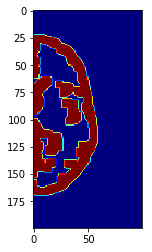

In [29]:
plt.imshow(seg_x[0][0].cpu().detach().numpy());

In [30]:
plt.imshow(filt[0][0].cpu().detach().numpy());

NameError: name 'filt' is not defined

In [84]:
input_grads = torch.autograd.grad(outputs=torch.abs(output[:,1]).sum(), #loss,#torch.abs(output).sum(), 
                                       inputs=b_x, 
                                       #retain_graph=True, 
                                       create_graph=True)[0]

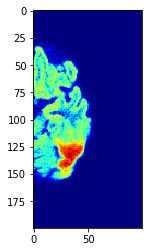

In [87]:
plt.imshow(b_x[10][0].cpu().detach().numpy())

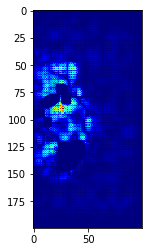

In [93]:
res = input_grads * (1-seg_x.float())
res = torch.abs(res)
plt.imshow(res[10][0].cpu().detach().numpy())

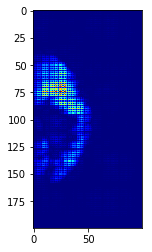

In [75]:
res = input_grads# * (1-seg_x.float())
res = torch.abs(res)
plt.imshow(res[5][0].cpu().detach().numpy())

In [ ]:
x, y = train[250]

In [ ]:
x[0].shape

In [ ]:
plt.imshow(x[0][0]);
plt.title(y);
plt.show()
plt.imshow(x[2][0]);

In [60]:
x_var = Variable(x[0].unsqueeze(0).cuda(), requires_grad=True)
pred = cnn(x_var)

RuntimeError: expected stride to be a single integer value or a list of 3 values to match the convolution dimensions, but got stride=[2, 2]

In [ ]:
test = torch.autograd.grad(outputs=torch.abs(pred[0]).sum(), 
                                       inputs=x_var, 
                                       retain_graph=True, 
                                       create_graph=True,
                                       grad_outputs=torch.FloatTensor([1]).cuda())

In [ ]:
input_grads = test[0][0][0].cpu().detach().numpy()

In [ ]:
plt.imshow(input_grads);

In [ ]:
# So much gradient!
plt.imshow(input_grads>0.0000001);

In [ ]:
plt.imshow(x[2][0])

In [ ]:
#these are the only allowed grads
masked_grads = input_grads*(x[2][0])
plt.imshow(masked_grads)

In [ ]:
#We can regularize to reduce this
masked_grads = input_grads*(1-x[2][0])
plt.imshow(masked_grads)

In [ ]:
import skimage.filters
enlarged_mask = skimage.filters.gaussian(x[2][0].numpy(),15)
enlarged_mask = enlarged_mask/enlarged_mask.max()
enlarged_mask.max()

In [ ]:
plt.imshow(enlarged_mask)

In [ ]:
#assuming the segmentations are sloppy we can enlarge the segmentations
masked_grads = input_grads*(1-enlarged_mask)
plt.imshow(masked_grads)

In [ ]:
#torch.save(cnn.state_dict(), "./classifier_model.pth")

In [ ]:
checkpoint = torch.load("./classifier_model.pth")
cnn.load_state_dict(checkpoint)

In [ ]:
# cnn.eval()
# test_output, last_layer = cnn(valid_x)
# pred_y = torch.max(test_output, 1)[1].data.squeeze()
# accuracy = float((pred_y == valid_y).sum()) / float(valid_y.size(0))
# print 'valid accuracy: %.2f' % accuracy

In [16]:
import pandas, os, pickle

In [62]:
df = pandas.DataFrame()
for f in os.listdir("stats"):
    d = (pickle.load(open("stats/" + f,"rb")))
    df = df.append(pandas.DataFrame(d))

In [63]:
df.nsamples.unique()

array([ 20,  10,  50, 100])

In [64]:
df[(df.nsamples == 10)].groupby(["epoch","thing"]).count()

nsamples  seed  trainloss  validauc
epoch thing                                     
0     False        11    11         11        11
      True         11    11         11        11
1     False        11    11         11        11
      True         11    11         11        11
2     False        11    11         11        11
      True         11    11         11        11
3     False        11    11         11        11
      True         11    11         11        11
4     False        11    11         11        11
      True         11    11         11        11
5     False        11    11         11        11
      True         11    11         11        11
6     False        11    11         11        11
      True         11    11         11        11
7     False        11    11         11        11
      True         11    11         11        11
8     False        11    11         11        11
      True         11    11         11        11
9     False        11    11         11        11
      True         11    11         11        11
10    False        11    11         11        11
      True         11    11         11        11
11    False        11    11         11        11
      True         11    11         11        11
12    False        11    11         11        11
      True         11    11         11        11
13    False        11    11         11        11
      True         11    11         11        11
14    False        11    11         11        11
      True         11    11         11        11
...               ...   ...        ...       ...
285   False        11    11         11        11
      True         11    11         11        11
286   False        11    11         11        11
      True         11    11         11        11
287   False        11    11         11        11
      True         11    11         11        11
288   False        11    11         11        11
      True         11    11         11        11
289   False        11    11         11        11
      True         11    11         11        11
290   False        11    11         11        11
      True         11    11         11        11
291   False        11    11         11        11
      True         11    11         11        11
292   False        11    11         11        11
      True         11    11         11        11
293   False        11    11         11        11
      True         11    11         11        11
294   False        11    11         11        11
      True         11    11         11        11
295   False        11    11         11        11
      True         11    11         11        11
296   False        11    11         11        11
      True         11    11         11        11
297   False        11    11         11        11
      True         11    11         11        11
298   False        11    11         11        11
      True         11    11         11        11
299   False        11    11         11        11
      True         11    11         11        11

[600 rows x 4 columns]

In [65]:
df[(df.nsamples == 10)].groupby(["epoch","thing", "seed"]).mean()

nsamples     trainloss  validauc
epoch thing seed                                  
0     False 0           10  6.909901e-01  0.500000
            1           10  7.044612e-01  0.500000
            2           10  6.815735e-01  0.500000
            3           10  6.941864e-01  0.500000
            4           10  7.000310e-01  0.500000
            5           10  6.906151e-01  0.500000
            6           10  6.962618e-01  0.489275
            7           10  7.156295e-01  0.500000
            8           10  7.027777e-01  0.500000
            9           10  6.839601e-01  0.500000
            10          10  6.777557e-01  0.500000
      True  0           10  6.916828e-01  0.500000
            1           10  7.056744e-01  0.500000
            2           10  6.825090e-01  0.500000
            3           10  6.950824e-01  0.500000
            4           10  7.002391e-01  0.500000
            5           10  6.911469e-01  0.500000
            6           10  6.968128e-01  0.489211
            7           10  7.165449e-01  0.500000
            8           10  7.033114e-01  0.500000
            9           10  6.844565e-01  0.500000
            10          10  6.802919e-01  0.500000
1     False 0           10  6.869643e-01  0.500000
            1           10  6.879351e-01  0.500000
            2           10  6.707098e-01  0.500000
            3           10  6.926903e-01  0.498564
            4           10  6.956859e-01  0.500000
            5           10  6.869649e-01  0.500000
            6           10  6.930293e-01  0.500000
            7           10  7.087072e-01  0.500000
...                    ...           ...       ...
298   True  3           10  1.232337e-04  0.686989
            4           10  2.960835e-05  0.614466
            5           10  6.032019e-05  0.694235
            6           10  2.418432e-04  0.575077
            7           10  1.142117e-05  0.520748
            8           10  1.176418e-04  0.609582
            9           10  1.886766e-06  0.563075
            10          10  3.827612e-05  0.635725
299   False 0           10  7.629395e-07  0.713611
            1           10  1.134872e-05  0.569937
            2           10  3.653765e-05  0.595761
            3           10  5.512237e-05  0.695289
            4           10  2.703905e-04  0.653856
            5           10  6.973743e-05  0.591739
            6           10  7.827282e-05  0.520748
            7           10  2.026558e-06  0.537474
            8           10  3.576279e-06  0.611115
            9           10  5.763513e-02  0.587206
            10          10  2.353191e-05  0.567511
      True  0           10  4.887096e-05  0.707769
            1           10  5.859102e-05  0.605561
            2           10  6.628253e-05  0.611178
            3           10  1.194894e-04  0.686989
            4           10  2.942748e-05  0.614466
            5           10  5.999787e-05  0.694235
            6           10  2.397482e-04  0.575077
            7           10  1.142175e-05  0.520748
            8           10  1.212014e-04  0.609582
            9           10  1.873726e-06  0.563075
            10          10  3.809525e-05  0.632884

[6600 rows x 3 columns]

11

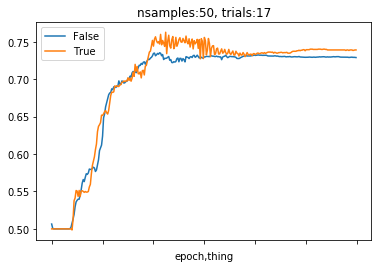

In [85]:
fig, ax = plt.subplots()
thisdata = df[(df.nsamples == 50)]
r = thisdata.groupby(["epoch","thing"]).mean().groupby("thing").plot(y="validauc", ax=ax)
plt.legend(df.thing.unique());
plt.title("nsamples:" + str(thisdata.nsamples.unique()[0]) + ", trials:" + str(thisdata.seed.unique().shape[0]));

In [37]:
# fig, ax = plt.subplots()
# r = ss.mean().groupby("thing").plot(y="validauc", ax=ax, yerr=ss.std())
# #plt.legend(r)


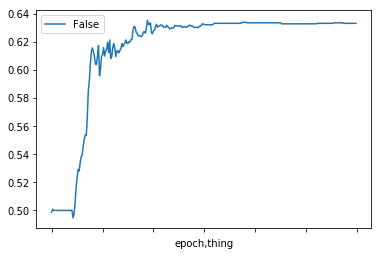

thing
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

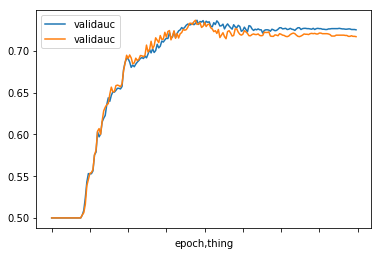

In [33]:
fig, ax = plt.subplots()
df[(df.nsamples == 50)].groupby(["epoch","thing"]).mean().groupby("thing").plot(y="validauc", ax=ax)

thing  nsamples
False  10          AxesSubplot(0.125,0.125;0.775x0.755)
       50          AxesSubplot(0.125,0.125;0.775x0.755)
       500         AxesSubplot(0.125,0.125;0.775x0.755)
True   10          AxesSubplot(0.125,0.125;0.775x0.755)
       50          AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

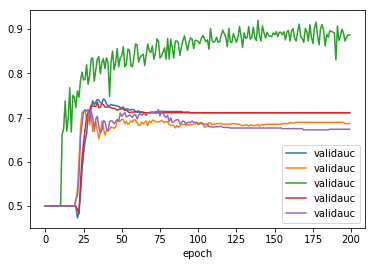

In [18]:
fig, ax = plt.subplots()
df.head(1000).groupby(["thing","nsamples"]).plot(x="epoch", y="validauc", ax=ax)

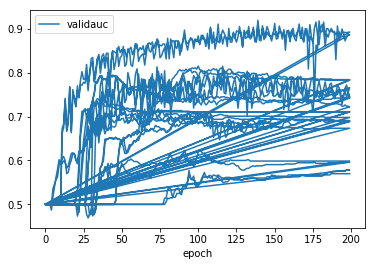

In [72]:
df.plot(x="epoch", y="validauc")